# Morse grid imports

Here we look at applied examples to import data for use in Dr Peter Morse 3D visualtsation software _(in prep.)_. Data must be exported as $1800 \times 3600$ px png files. This might change in future. 

Generally, the code in this tutorial runs rather slow as there is a large amount of interpolation. Have patience. 

Folder `../local` is used to download data and export pngs. 

This notebook also show some real examples of how agrid can be used. 

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
#import warnings
#warnings.filterwarnings('ignore')

config_file = "../agrid/agrid.py"
#with open(config_file) as f:
#    code = compile(f.read(), config_file, 'exec')
#    exec(code, globals(), locals())

# ... or use you Python path or present working directory:
import sys, os
sys.path.append('..')

from agrid.agrid.grid import Grid
from agrid.acc import download

import numpy as np

from matplotlib import pyplot as plt

import vtk
from vtk.util.numpy_support import vtk_to_numpy

In [46]:
import inspect
print(inspect.getmodule(Grid))

<module 'agrid.agrid.grid' from '../agrid/agrid/grid.py'>


In [54]:
from morse_2019 import export_png

## SMEAN2

Download the mantel model from from Becker and Boschi, The University of Texas at Austin. See original paper [Becker and_Boschi 2002](http://www-udc.ig.utexas.edu/external/becker/becker_and_boschi_2002.pdf) for details. SMEAN2 contains additional datasets. (This was written before download functions wrere implimented in agrid, and is kept as an example of the functionlality in Jupyter.)

In [20]:
! mkdir -p ../../data/smean2
! wget -nc http://www-udc.ig.utexas.edu/external/becker/ftp/smean2_grd.tgz \
    -O ../../data/smean2/smean_grd.tgz
! tar -xvzf ../../data/smean2/smean_grd.tgz -C ../../data/

! printf "\n"
! cat ../../data/smean2/README

File ‘../../data/smean2/smean_grd.tgz’ already there; not retrieving.
x smean2/
x smean2/dvs.8.grd
x smean2/dvs.32.grd
x smean2/dvs.15.grd
x smean2/dvs.29.grd
x smean2/dvs.17.grd
x smean2/dvs.28.grd
x smean2/convert
x smean2/dvs.44.grd
x smean2/dvs.27.grd
x smean2/dvs.55.grd
x smean2/dvs.58.grd
x smean2/dvs.22.grd
x smean2/dvs.20.grd
x smean2/dvs.6.grd
x smean2/dvs.53.grd
x smean2/dvs.11.grd
x smean2/dvs.38.grd
x smean2/dvs.33.grd
x smean2/dvs.1.grd
x smean2/dvs.13.grd
x smean2/dvs.49.grd
x smean2/depths.dat
x smean2/dvs.50.grd
x smean2/dvs.30.grd
x smean2/d.31.model.ab
x smean2/dvs.9.grd
x smean2/dvs.42.grd
x smean2/dvs.54.grd
x smean2/dvs.43.grd
x smean2/dvs.31.grd
x smean2/dvs.47.grd
x smean2/dvs.24.grd
x smean2/dvs.7.grd
x smean2/dvs.14.grd
x smean2/dvs.4.grd
x smean2/dvs.39.grd
x smean2/dvs.34.grd
x smean2/dvs.48.grd
x smean2/dvs.23.grd
x smean2/README
x smean2/dvs.5.grd
x smean2/dvs.46.grd
x smean2/dvs.51.grd
x smean2/dvs.19.grd
x smean2/dvs.16.grd
x smean2/dvs.41.grd
x smean2/dv

In this example, the data is global and we define a grid with the right rsolution from start. However, as we will see later, we could work on regional data as well. The exported png will always have a global coverage with alpha covering the excluded areas. 

We read depth values for smean from a provided ascii file. However we also have a regular depth dimention, defined as regular 50km depths. 

In [21]:
#columns from left to right represent radius,depth,density,Vpv,Vph,Vsv,Vsh,eta,Q-mu,Q-kappa
km = 1000

smean_depths = km * np.loadtxt('../../../data/smean2/depths.dat')
max_depth = np.max(smean_depths)

depths = km * np.array([*range(20, 1000, 20)] + [*range(1000, int(max_depth)//km, 50)])

prem_d, prem_vsv, prem_vsh = km * np.loadtxt('../../../data/models/PREM_1s.csv', 
                              delimiter = ',', 
                              usecols = [1, 5, 6],
                              unpack=True)

prem_vsv = prem_vsv[prem_d < max_depth]
prem_vsh = prem_vsh[prem_d < max_depth]
prem_d = prem_d[prem_d < max_depth]

print(depths)
print(smean_depths)

[  20000   40000   60000   80000  100000  120000  140000  160000  180000
  200000  220000  240000  260000  280000  300000  320000  340000  360000
  380000  400000  420000  440000  460000  480000  500000  520000  540000
  560000  580000  600000  620000  640000  660000  680000  700000  720000
  740000  760000  780000  800000  820000  840000  860000  880000  900000
  920000  940000  960000  980000 1000000 1050000 1100000 1150000 1200000
 1250000 1300000 1350000 1400000 1450000 1500000 1550000 1600000 1650000
 1700000 1750000 1800000 1850000 1900000 1950000 2000000 2050000 2100000
 2150000 2200000 2250000 2300000 2350000 2400000 2450000 2500000 2550000
 2600000 2650000 2700000 2750000 2800000 2850000]
[2875000. 2825000. 2775000. 2725000. 2675000. 2625000. 2575000. 2525000.
 2475000. 2425000. 2375000. 2325000. 2275000. 2225000. 2175000. 2125000.
 2075000. 2025000. 1975000. 1925000. 1875000. 1825000. 1775000. 1725000.
 1675000. 1625000. 1575000. 1525000. 1475000. 1425000. 1375000. 1325000.
 

In [22]:
world = Grid(crs_tgt = 4326, 
             left= -180, up=90, down= -90, right=180.0, 
             res=(0.09999,0.09999), 
             depths = depths)

array = np.empty((world.ny, world.nx, world.ds.coords['Z'].size))
array[:] = np.nan
print(world.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 3600, X_edge: 3601, Y: 1800, Y_edge: 1801, Z: 87, Z_edge: 88)
Coordinates:
  * X        (X) float32 -180.0 -179.89998 -179.79994 ... 179.89998 180.0
  * Y        (Y) float32 -90.0 -89.89995 -89.79989 ... 89.79989 89.89995 90.0
  * Z        (Z) float32 20000.0 40000.0 60000.0 ... 2800000.0 2850000.0
  * X_edge   (X_edge) float32 -180.04999 -179.94997 ... 179.94997 180.04999
  * Y_edge   (Y_edge) float32 -90.049995 -89.949936 ... 89.949936 90.049995
  * Z_edge   (Z_edge) float64 1e+04 3e+04 5e+04 ... 2.825e+06 2.875e+06
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    YV       (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    lat      (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    lon      (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
Data variables:
    *empty*


In [23]:
world.ds['PREM_VSV'] = (('Z'), world.change_coord(prem_vsv, prem_d, 'Z') )

Now, we can read SMEAN files. set_center alows us to read 0-360 as -180 - 180 lon. read_grid uses default nearest neighbour interpolation of datapoints to fit the predefined Morse grid. 

In [24]:
world.ds.coords['SMEAN_Z'] = smean_depths

print(world.ds)

<xarray.Dataset>
Dimensions:   (RGB: 3, SMEAN_Z: 58, X: 3600, X_edge: 3601, Y: 1800, Y_edge: 1801, Z: 87, Z_edge: 88)
Coordinates:
  * X         (X) float32 -180.0 -179.89998 -179.79994 ... 179.89998 180.0
  * Y         (Y) float32 -90.0 -89.89995 -89.79989 ... 89.79989 89.89995 90.0
  * Z         (Z) float32 20000.0 40000.0 60000.0 ... 2800000.0 2850000.0
  * X_edge    (X_edge) float32 -180.04999 -179.94997 ... 179.94997 180.04999
  * Y_edge    (Y_edge) float32 -90.049995 -89.949936 ... 89.949936 90.049995
  * Z_edge    (Z_edge) float64 1e+04 3e+04 5e+04 ... 2.825e+06 2.875e+06
  * RGB       (RGB) <U1 'R' 'G' 'B'
    XV        (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    YV        (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    lat       (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
    lon       (Y, X) float32 dask.array<shape=(1800, 3600), chunksize=(180, 360)>
  * SMEAN_Z   (SMEAN_Z) float64 2.875e+06 2.825e+0

In [25]:
smean_array = np.empty((world.ny, world.nx, smean_depths.size))

for i, a in enumerate(smean_depths):
    print(a//km, end=', ')
    index_name = smean_depths//km - i # Get right file name for each depth
    fname = '../../../data/smean2/dvs.%s.grd'%(i+1)
    if os.path.isfile(fname):
        smean_array[:,:,i] = world.read_grid(fname, xyz = ('lon','lat','z'), set_center = True, pad_around = True)
        
smean_array /= 100    #"The grid file values are given are percentage v_S wave 
#                #speed variation related to PREM, with layer averages removed."
    
print(smean_array[:14,:14,25])

2875.0, JHJHJHJ
2825.0, JHJHJHJ
2775.0, JHJHJHJ
2725.0, JHJHJHJ
2675.0, JHJHJHJ
2625.0, JHJHJHJ
2575.0, JHJHJHJ
2525.0, JHJHJHJ
2475.0, JHJHJHJ
2425.0, JHJHJHJ
2375.0, JHJHJHJ
2325.0, JHJHJHJ
2275.0, JHJHJHJ
2225.0, JHJHJHJ
2175.0, JHJHJHJ
2125.0, JHJHJHJ
2075.0, JHJHJHJ
2025.0, JHJHJHJ
1975.0, JHJHJHJ
1925.0, JHJHJHJ
1875.0, JHJHJHJ
1825.0, JHJHJHJ
1775.0, JHJHJHJ
1725.0, JHJHJHJ
1675.0, JHJHJHJ
1625.0, JHJHJHJ
1575.0, JHJHJHJ
1525.0, JHJHJHJ
1475.0, JHJHJHJ
1425.0, JHJHJHJ
1375.0, JHJHJHJ
1325.0, JHJHJHJ
1275.0, JHJHJHJ
1225.0, JHJHJHJ
1175.0, JHJHJHJ
1125.0, JHJHJHJ
1075.0, JHJHJHJ
1025.0, JHJHJHJ
975.0, JHJHJHJ
925.0, JHJHJHJ
875.0, JHJHJHJ
825.0, JHJHJHJ
775.0, JHJHJHJ
725.0, JHJHJHJ
675.0, JHJHJHJ
625.0, JHJHJHJ
575.0, JHJHJHJ
525.0, JHJHJHJ
475.0, JHJHJHJ
425.0, JHJHJHJ
375.0, JHJHJHJ
325.0, JHJHJHJ
275.0, JHJHJHJ
225.0, JHJHJHJ
175.0, JHJHJHJ
125.0, JHJHJHJ
75.0, JHJHJHJ
25.0, JHJHJHJ
[[0.00145861 0.00145861 0.00145861 0.00145861 0.00145861 0.00145861
  0.00145861 0.00145861 0.

In [26]:
world.ds['SMEAN'] = (('Y', 'X', 'SMEAN_Z'), smean_array)


print(world.ds.SMEAN_Z)

world.map_grid(world.ds.SMEAN.sel(SMEAN_Z=75*km))

[autoreload of agrid.agrid.grid failed: Traceback (most recent call last):
  File "/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 317, in update_instance

<xarray.DataArray 'SMEAN_Z' (SMEAN_Z: 58)>
array([2875000., 2825000., 2775000., 2725000., 2675000., 2625000., 2575000.,
       2525000., 2475000., 2425000., 2375000., 2325000., 2275000., 2225000.,
       2175000., 2125000., 2075000., 2025000., 1975000., 1925000., 1875000.,
       1825000., 1775000., 1725000., 1675000., 1625000., 1575000., 1525000.,
       1475000., 1425000., 1375000., 1325000., 1275000., 1225000., 1175000.,
       1125000., 1075000., 1025000.,  975000.,  925000.,  875000.,  825000.,
        775000.,  725000.,  675000.,  625000.,  575000.,  525000.,  475000.,
        425000.,  375000.,  325000.,  275000.,  225000.,  175000.,  125000.,
         75000.,   25000.])
Coordinates:
  * SMEAN_Z  (SMEAN_Z) float64 2.875e+06 2.825e+06 2.775e+06 ... 7.5e+04 2.5e+04


../agrid/agrid/grid.py:1173: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution=map_res,


KeyboardInterrupt: 

In [27]:
world.ds.SMEAN.sel(SMEAN_Z=75*km).values[1000,0]

0.01785030737492207

Finally, we export the 3D grids as png files for each depth slice. We store a set of original depth slices in ''morse/smean/z_orig/' and also the interpolated depth slices in 'morse/smean/z_even/'. This might take some time. 

In [28]:
smean_min = np.nanmin(smean_array)
smean_max = np.nanmax(smean_array)

print(smean_min, smean_max)

-0.12535165761833922 0.07612317009959951


In [29]:
#new_smean_array  = world.change_coord(smean_array, old=smean_depths, new='Z')

KeyboardInterrupt: 

In [ ]:
#np.shape(new_smean_array)

In [ ]:
#world.ds['SMEAN_INTERPOL'] = (('Y', 'X', 'Z'), new_smean_array)

In [ ]:
import pickle
#pickle.dump(world, open( "../local/world.p", "wb" ), protocol=4)
#w = open( "../local/world.p", "wb" )
#pickle.dump(world,w,protocol=pickle.HIGHEST_PROTOCOL)
#world = pickle.load( open( "../local/world.p", "rb" ) )

In [ ]:
! mkdir -p ../local/morse/smean2

In [30]:
clip_min = -0.024
clip_max = 0.024

We have a quick look at the interpolation for some test pixels, it looks OK. 

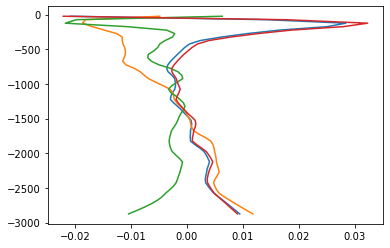

In [31]:
test_pixels = [(12,12),(123,123),(500,500),(0,0)]

for test_pixel in test_pixels:
    plt.plot(world.ds['SMEAN'][test_pixel[0],test_pixel[1],:], -world.ds['SMEAN_Z']/km)

First we convert the original depths to png rasters. We clip the values to +/- 2.4%:

In [58]:
depths = world.ds['SMEAN_Z']

csv_file = "../local/morse/smean2/log_smean2_8rgb_clip_24_24.csv"
header = '''depth, png_file, clip_min, clip_max, bit_depth, interpolation, min in data, max in data, min normalised, max normalised, min to png, max to png, min from png, max from png \n'''

with open(csv_file, "w") as log_file:
    log_file.write(header)

for z in depths[::-1]:
    layer_data = world.ds['SMEAN'].sel(SMEAN_Z=z).values
    if np.isfinite(layer_data).any():
        report = export_png(world,
                        data = layer_data, 
                        png_name = '../local/morse/smean2/%04d_smean2.png'%(int(z)//km), 
                        v_min = clip_min, v_max = clip_max,
                        clip = True, 
                        flip=True,
                        png_format = 'RGB',
                        set_geometry = False)
        print(report)
        with open(csv_file, "a") as log_file:
            log_file.write('%s, %s \n'%(z.values , report))
    else:
        print('only nan:',z)
    

greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/0025_smean2.png, -0.024, 0.024, 8, nearest, -0.12535165761833922, 0.0616335960167271, 0.0, 1.0, 0.0, 255.0, 0, 255
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/0075_smean2.png, -0.024, 0.024, 8, nearest, -0.07394451145304629, 0.06600640689681313, 0.0, 1.0, 0.0, 255.0, 0, 255
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/0125_smean2.png, -0.024, 0.024, 8, nearest, -0.06561713460108877, 0.07612317009959951, 0.0, 1.0, 0.0, 255.0, 0, 255
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/0175_smean2.png, -0.024, 0.024, 8, nearest, -0.04738297446398065, 0.06784743098185572, 0.0, 1.0, 0.0, 255.0, 0, 255
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/02

greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/1675_smean2.png, -0.024, 0.024, 8, nearest, -0.018131548719479723, 0.013265715351662948, 0.12156862745098039, 0.7764705882352941, 31.0, 198.0, 31, 198
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/1725_smean2.png, -0.024, 0.024, 8, nearest, -0.018909117780581255, 0.013985251509557201, 0.10588235294117647, 0.792156862745098, 27.0, 202.0, 27, 202
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/1775_smean2.png, -0.024, 0.024, 8, nearest, -0.019594988202934472, 0.01466500129717133, 0.09019607843137255, 0.803921568627451, 23.0, 205.0, 23, 205
greyscale: False
alpha: False
planes: 3
bitdepth: 8
interlace: 0
size: (3600, 1800)

../local/morse/smean2/1825_smean2.png, -0.024, 0.024, 8, nearest, -0.020090510660929796, 0.014814226828384562, 0.08235294117647059, 0.8078431372

Text(0.5, 0, 'png pixel values (8-bits)')

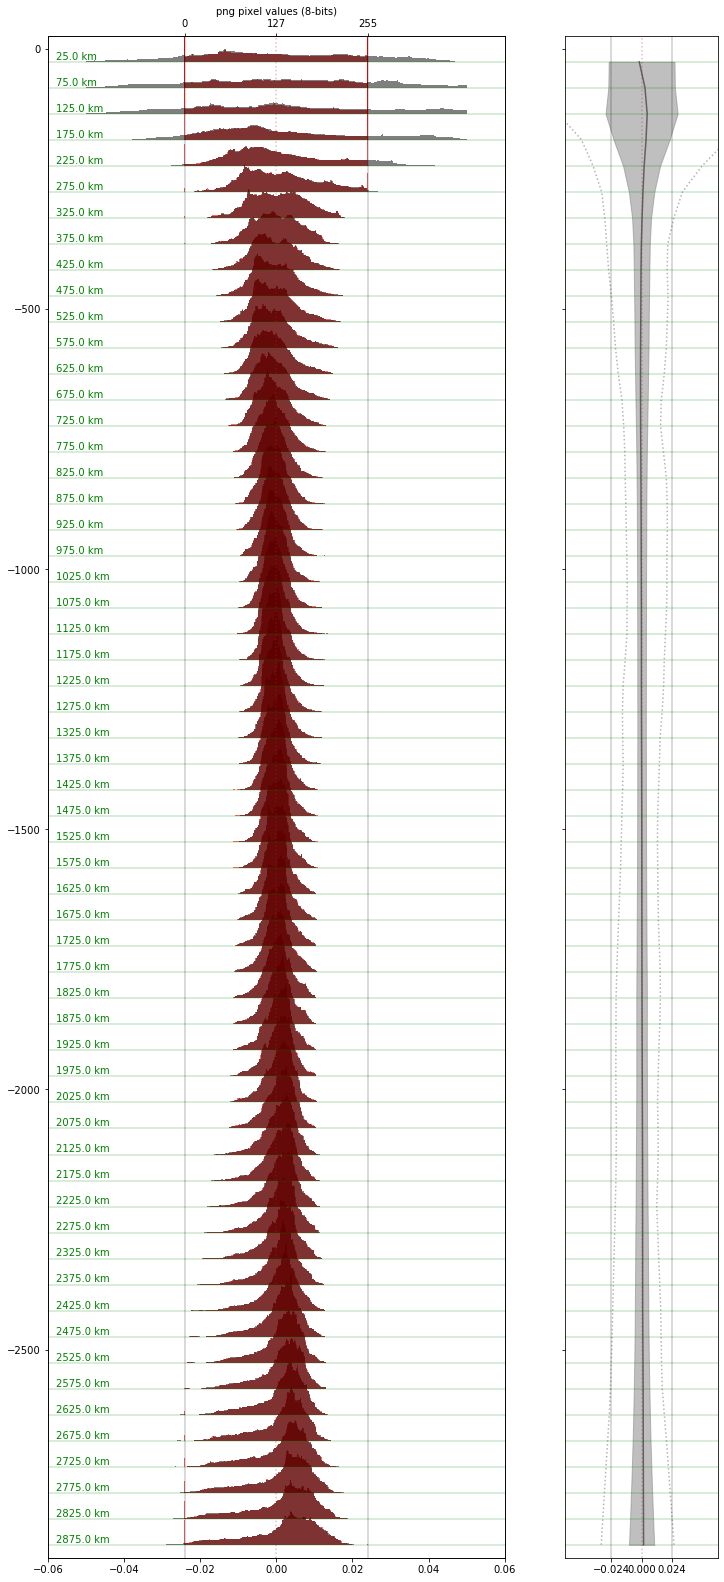

In [25]:
fig, ax = plt.subplots(ncols=2,
                       figsize= (12,28), 
                       gridspec_kw={'width_ratios': [3, 1]}, 
                       sharey=True)
turbo = 1

from scipy.optimize import curve_fit
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

#depths_smean = world.ds['SMEAN_Z'][::-1]


ax[0].set_xlim(-0.06,0.06)
ax[1].set_xlim(-0.06,0.06)
ax[0].set_ylim(-2900,25)
    
    
mean_p = np.nanmean(world.ds['SMEAN'].values, axis=(0,1))
std_p = np.nanstd(world.ds['SMEAN'].values, axis=(0,1))
max_p = np.nanmax(world.ds['SMEAN'].values, axis=(0,1))
min_p = np.nanmin(world.ds['SMEAN'].values, axis=(0,1))

d = -world.ds['SMEAN_Z'].values/1000
ax[1].fill_betweenx(d,-std_p, std_p,interpolate=True, color='gray', alpha=0.5)
ax[1].plot(mean_p, d, c='k', ls='-', alpha=0.5)

ax[1].plot(min_p, d, c='k', ls=':', alpha=0.3)
ax[1].plot(max_p, d, c='k', ls=':', alpha=0.3)
ax[1].set_xticks(np.array([clip_min, 0, clip_max]))



ax[1].axvline(0, c='brown', alpha=0.3, ls=':')    
ax[1].axvline(clip_min, c='k', alpha=0.2)
ax[1].axvline(clip_max, c='k', alpha=0.2)

for i, z in enumerate(world.ds['SMEAN_Z']):
    layer_data = world.ds['SMEAN'].sel(SMEAN_Z=z).values.flatten()[::turbo]
    d = z.values // 1000
    
    #print(d)
    ax[0].axhline(-d, c='green', alpha=0.2)
    ax[1].axhline(-d, c='green', alpha=0.2)
    ax[0].text(-0.058,5-d,'%s km'%d, c='green')
        
    if np.isfinite(layer_data).any():
        clip_layer = np.clip(layer_data, clip_min, clip_max)
        
        counts, bins = np.histogram(clip_layer, 
                                        bins = 301,
                                        range=(-0.05,0.04))
        
    
        counts = counts//3000  
        bin_heights, bin_borders, _ = ax[0].hist(bins[:-1], bins, weights=counts,
                                        label='histogram', 
                                        bottom= -d, 
                                        density = True,      
                                        color = 'r', alpha=0.6)
        
    
    
        counts, bins = np.histogram(layer_data, 
                                        bins = 301,
                                        range=(-0.05,0.05))
        
        counts = counts//3000
        bin_heights, bin_borders, _ = ax[0].hist(bins[:-1], bins, weights=counts,
                                        label='histogram', 
                                        bottom= -d, 
                                        density = True,      
                                        color = 'k', alpha=0.5)
        
            
ax[0].axvline(0, c='brown', alpha=0.3, ls=':')
ax[0].axvline(clip_min, c='k', alpha=0.2)
ax[0].axvline(clip_max, c='k', alpha=0.2)


ax_png = ax[0].twiny()
bit_depth = 8
ax_png.set_xlim(-0.06,0.06)
ax_png.set_xticks(np.array([clip_min, 0, clip_max]))
ax_png.set_xticklabels(np.array([0, 2**bit_depth//2-1, 2**bit_depth-1]))
ax_png.set_xlabel('png pixel values (8-bits)')

## GLAD M15

Now let's import the model from [Bozdağ et al (2016)](https://academic.oup.com/gji/article/207/3/1739/2404568). Unfortunately, it appears that the data is not availible from any open repo (?!), but I belive that the group is willing to assist if contacted. 

The SMEAN data was easy to import, but exporting the GLAD-M15 data is more compicated as I only get access to an unstructured grid, in a normalised space. 

In [ ]:
# load a vtk file to reader
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName('../local/GLAD-M15/reg_1_dvsv.vtu')
reader.Update()

# Get the coordinates of nodes in the mesh
nodes_vtk_array= reader.GetOutput().GetPoints().GetData()

#The data field is the first scalar in the vtu file
data_vtk_array = reader.GetOutput().GetPointData().GetArray(0)

print(data_vtk_array, nodes_vtk_array)

We get two arrays. Note that sizes are equal (Number Of Tuples: 4712064 and Number Of Tuples: 4712064) and the coordinate are 3D (NumberOfComponents: 3). Read coordinates and data as numpy arrays and have a look: 

In [ ]:
nodes_numpy_array = vtk_to_numpy(nodes_vtk_array)
X, Y, Z = nodes_numpy_array[:,0] , nodes_numpy_array[:,1] , nodes_numpy_array[:,2]
V = vtk_to_numpy(data_vtk_array)

print(X[:10],Y[:10],Z[:10],V[:10], sep='\n\n')

The coordinates are stored in the range [-1..1]. We assume a spherical Earth and compute an array with every points distance from centre. Function `sphere_to_layer()` takes a slice from the sphere and save to a 2D array. delta_r should be as small as possible, for best vertical resolution, but if too few points are used the vertical resolution gets bad. 

We loop through the harmonics of the sphere and read all points within a spherical shell defined by the radius +/- delta_r

In [ ]:
def sphere_to_layer(d, R, V, LAT, LON, xxx, yyy, 
                    delta_r = 32*km, 
                    min_s = 5000,
                    r_earth =  (6357*km + 6378*km) / 2, 
                    interpolation = 'nearest'):
    
    A = np.zeros_like(xxx).astype('float')
    A[:] = np.nan
    upper = 1-(d-delta_r)/r_earth
    lower = 1-(d+delta_r)/r_earth
    S = (R > lower) & (R < upper) # Select points in spherical shell
    s_sum = np.count_nonzero(S) # Check how many points in shell

    if s_sum >= min_s:
        A = interpolate.griddata((LON[S], LAT[S]),
                V[S], (xxx, yyy), method = interpolation)
    print(d//1000, 'km \t N=', sum(S),u'\t \N{BLACK RIGHT-POINTING TRIANGLE}', np.nanmean(A))
    return np.flipud(A) #Because ulike lat, rows start from top. 

R = np.sqrt(X*X + Y*Y + Z*Z) # The distance from each point to centre of spherical Earth. 

LAT = world.shape3[0]/180 * (np.arccos( Z / R) * 180/np.pi) 
LON = world.shape3[1]/360 * (np.arctan2(Y, X) * 180/np.pi + 180)

xxx, yyy = np.meshgrid(range(0, world.shape3[1]), range(world.shape3[0], 0, -1)) 

glad = np.zeros(world.shape3) # self.shape3 is a tuple of the models dimensions

for i, d in enumerate(world.ds['Z'].values):
    glad[:,:,i] = sphere_to_layer(d, R, V, LAT, LON, xxx, yyy)

Unfortunately there are not enugh data points at 1350, 1450, 2150 and 2250 km depth. We'd need to look in a broad spherical shell to get datapoints: 

In [ ]:
missing_i, missing_d = [], []

for i in range(glad.shape[2]):
    if (np.count_nonzero(np.isnan(glad[:,:,i]) ) > 1000):
        missing_i.append(i)
        missing_d.append(world.ds['Z'].values[i])
      
for i,d in zip(missing_i, missing_d):
    print(i, end=' ')
    glad[:,:,i] = sphere_to_layer(d, R, V, LAT, LON, xxx, yyy, delta_r = 45*km)    

However, we can be more precise with the first layer. 

In [ ]:
glad[:,:,0] = sphere_to_layer(50*km, R, V, LAT, LON, xxx, yyy, delta_r = 14*km)   
glad[:,:,1] = sphere_to_layer(150*km, R, V, LAT, LON, xxx, yyy, delta_r = 20*km)   

We save the array to the object and have a look. 

In [ ]:
world.ds['GLAD'] = (('Y', 'X', 'Z'), glad)
glad_min = np.nanmin(world.ds['GLAD'].values)
glad_max = np.nanmax(world.ds['GLAD'].values)

print(glad_min, glad_max)
#print(smean_min, smean_max)

z_map = 0
world.map_grid(world.ds['GLAD'].isel(Z=z_map), cmap='magma_r', vmin=-0.06, vmax=0.06)
#world.map_grid(world.ds['SMEAN'].isel(Z=z_map), cmap='magma_r', vmin=-0.06, vmax=0.06)

In [ ]:
world.ds['DIFF'] = world.ds['GLAD']-world.ds['SMEAN']

diff_min = np.nanmin(world.ds['DIFF'].values)
diff_max = np.nanmax(world.ds['DIFF'].values)

print(diff_min, diff_max)

world.map_grid(world.ds['DIFF'].isel(Z=z_map), cmap='BrBG', vmin=-0.06, vmax=0.06)

In [ ]:
! mkdir -p ../local/glad/16_bit

In [ ]:
for i, z in enumerate(world.ds['Z']):
    report = export_morse_png(world, world.ds['GLAD'].isel(Z=i).values, '../local/glad/16_bit/%04d_%s_glad.png'%(int(z)//km, i+1), 
                          v_min = glad_min, v_max = glad_max, 
                              set_geometry = False, 
                             png_format = 'RGB', 
                             bit_depth = 16)
    with open("../local/morse/glad/log_16bit.txt", "a") as log_file:
        log_file.write(report)
    print(report)
    

Save the grid: 

In [ ]:
world.save(world.ds, '../local/smean_and_glad.nc')

We could also interpolate new depth values to make a regular 3D grid. 

In [ ]:
world.ds['Z_NEW'] = range(0,2850*km, 100*km)

world.ds['SMEAN_INTER'] = ( ('Y', 'X', 'Z'), 
                           world.change_coord(world.ds['SMEAN'], world.ds['Z'], world.ds['Z_NEW']) )

In [ ]:
world.ds

# AuSREM

Australian crustal and lithospheric seismic model.

Can be downloaded from http://rses.anu.edu.au/seismology/AuSREM/Downloads/ We assume a local file: 

In [ ]:
fname = '../local/ausrem_SV_100.txt'
data = world.read_ascii(fname)

Make a mask, as the 'nearest neigbur' interpolation tested, will extrapolate values to all cells.

In [ ]:
alpha_master = np.isfinite(data)

plt.imshow(alpha_master)
plt.show()

Here, we test a number of different formats for the output png file: 

In [ ]:
for _format in ['L', 'LA', 'RGB', 'RGBA']:
    for _bit_depth in [8, 16]:
        for _interpol in ['nearest', 'linear', 'cubic']:
            data = world.read_ascii(fname, interpol =_interpol)
            
            if _interpol == 'nearest':
                how_confine = 'mask'
                mask_to_value = np.nan
            else:
                how_confine = 'input'
                mask_to_value = None
            
            report = export_morse_png(world,
                          data = data, 
                          png_format = _format,
                          png_name = '../local/AuSREM/AuSREM_100km_%s_%sbit_%s.png'%( _interpol,_bit_depth,_format),
                          interpol_method =  _interpol,
                          confine_data = how_confine,
                          confine_mask = alpha_master,
                        mask_to_value = mask_to_value,
                          v_min = 4, v_max = 5, 
                          clip=True,
                          set_geometry = False, 
                          bit_depth=_bit_depth)

            print(report)
            with open("../local/AuSREM_log.txt", "a") as log_file:
                log_file.write(report)

In [ ]:
!sips -g all ../local/AuSREM/AuSREM_100km_nearest_16bit_L.png
#!open ../local/new/AuSREM_100km_nearest_16bit_L.png

In [ ]:
world.ds

In [ ]:
world.map_grid('SMEAN'.sel(Z=1000) )

In [ ]:
lat, lon, persent